
# Classification of text documents using sparse features

Notebook created from https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html


In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

In [2]:
from time import time

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

data_dir = load_files('data', shuffle=False, encoding='utf-8', decode_error="ignore")

# order of labels in `target_names` can be different from `categories`
target_names = data_dir.target_names

stop_words = stopwords.words('french') + ["ça", "quand", "si", "comme", "tous", "cette", "faire", "non", "oui"]

# Extracting features from the training data using a sparse vectorizer
vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.5, min_df=5, stop_words=(stop_words)
)

X_train1, X_test1, y_train, y_test = train_test_split(
    data_dir.data, data_dir.target, test_size=0.3, random_state=125
)

X_train = vectorizer.fit_transform(X_train1)

# Extracting features from the test data using the same vectorizer
X_test = vectorizer.transform(X_test1)

feature_names = vectorizer.get_feature_names_out()

print(feature_names)
print(f"{len(X_train.toarray())} documents (training set)")
print(f"{len(X_test.toarray())} documents (test set)")
print(f"{len(target_names)} categories")
print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julien.bouquillon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['00' '000' '01' ... 'œuvre' 'œuvrer' 'œuvres']
3500 documents (training set)
1500 documents (test set)
4 categories
n_samples: 3500, n_features: 8698


Our first model is an instance of the
:class:`~sklearn.linear_model.RidgeClassifier` class. This is a linear
classification model that uses the mean squared error on {-1, 1} encoded
targets, one for each possible class. Contrary to
:class:`~sklearn.linear_model.LogisticRegression`,
:class:`~sklearn.linear_model.RidgeClassifier` does not
provide probabilistic predictions (no `predict_proba` method),
but it is often faster to train.



In [3]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import RidgeClassifier
import skops.io as sio

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average="macro")

accuracy = f"\nAccuracy =  {round(accuracy, 2)}, F1 Score = {round(f1, 2)}"

text = ["ils ont marqué cinq buts à zero"]

vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words=stop_words
    )
vectorizer.fit(X_train1)
text_vectorized = vectorizer.transform(text)

# Predict the category
prediction = clf.predict(text_vectorized)

print(text)
for i, pred2 in enumerate(prediction):
    print(target_names[prediction[i]])

sio.dump(clf, "model/model.skops")


['ils ont marqué cinq buts à zero']
Politique


We plot the confusion matrix of this classifier to find if there is a pattern
in the classification errors.



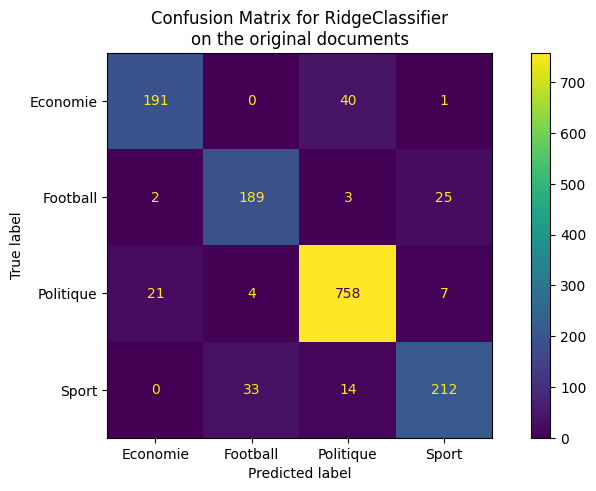

In [4]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)
fig.savefig("model/model-confusion-matrix.png")


top 5 keywords per class:
      Economie  Football     Politique   Sport
0     partager  partager      ministre  équipe
1   entreprise      club     président  france
2       groupe     match  gouvernement    2024
3  entreprises  football         parti  finale
4      annoncé    saison      candidat     ats


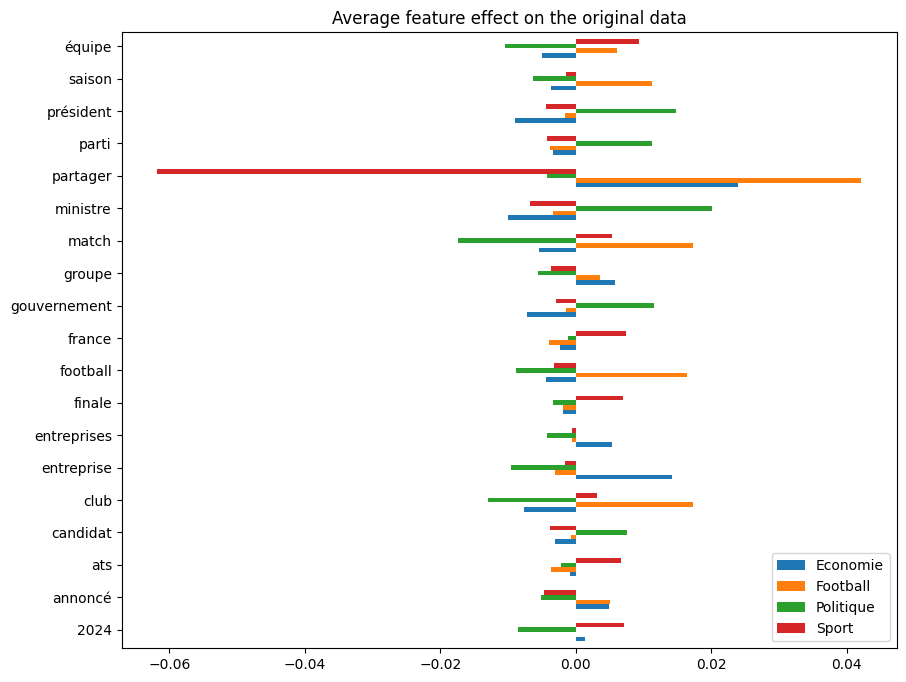

In [5]:
import numpy as np
import pandas as pd

stat_tops=""
def plot_feature_effects():
    global stat_tops
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")
    fig.savefig("model/model-feature-effect.png")
    print("top 5 keywords per class:")
    stat_tops=top
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")



In [6]:
from skl2onnx import to_onnx
import json
import numpy
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType,FloatTensorType
import onnxruntime

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', clf)
])

# Initial type for input data (adjust shape as needed)
initial_type = [('input', StringTensorType([None]))]

# Convert to ONNX
onnx_model = convert_sklearn(
    pipeline, 
    initial_types=initial_type, 
    target_opset=None  # Uses default opset,
)
# meta=onnx_model.metadata_props.add()
# meta.key = "key_meta"
# meta.value = "value_meta"

# Save ONNX model
with open(f"model/model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

x=json.dumps([name for name in target_names])
print(x)

# backup the features strings for the frontend
with open(f"model/model-features.json", "w") as f:
    f.write(x)



# vectorizer_onnx = convert_sklearn(
#     vectorizer, 
#     initial_types=[('input', StringTensorType([None]))],
#     target_opset=None
# )

# Save ONNX model
#with open(f"Model/vectorizer-{DATA_DIR}.onnx", "wb") as f:
#    f.write(vectorizer_onnx.SerializeToString())


#vect_session = onnxruntime.InferenceSession(f"Model/vectorizer-{DATA_DIR}.onnx")
#vect_input_name = vect_session.get_inputs()[0].name
#vect_output_name = vect_session.get_outputs()[0].name

#session = onnxruntime.InferenceSession(f"Model/{DATA_DIR}.onnx")
session = onnxruntime.InferenceSession(f"model/model.onnx")
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

text = "ils ont marqué 5 buts à 0"

# text_vectorized = vect_session.run(
#             [vect_output_name], 
#             {input_name: [text]}
#         )[0]

#text_vectorized = vect.transform([text])
#input_data = text_vectorized
#.toarray().astype(np.float32)

prediction = session.run([output_name], {input_name: [text]})[0]
#print(prediction)
#predicted_category = target_names[prediction[0]]
print([target_names[category] for category in prediction])
#print(predicted_category)


["Economie", "Football", "Politique", "Sport"]
['Politique']


In [7]:
markdown="# Model report\n\n"
markdown+=accuracy+"\n\n"
markdown+="## Confusion matrix\n\n"
markdown+="![confusion matrix](./model-confusion-matrix.png)\n\n"
markdown+="## Feature effect\n\n"
markdown+="### Top 5 keywork per feature\n\n"
markdown += (stat_tops.to_markdown() + "\n\n")
markdown+="\n\n![confusion matrix](./model-feature-effect.png)\n\n"
with open("model/report.md", "w") as f:
    f.write(markdown)

markdown

'# Model report\n\n\nAccuracy =  0.9, F1 Score = 0.87\n\n## Confusion matrix\n\n![confusion matrix](./model-confusion-matrix.png)\n\n## Feature effect\n\n### Top 5 keywork per feature\n\n|    | Economie    | Football   | Politique    | Sport   |\n|---:|:------------|:-----------|:-------------|:--------|\n|  0 | partager    | partager   | ministre     | équipe  |\n|  1 | entreprise  | club       | président    | france  |\n|  2 | groupe      | match      | gouvernement | 2024    |\n|  3 | entreprises | football   | parti        | finale  |\n|  4 | annoncé     | saison     | candidat     | ats     |\n\n\n\n![confusion matrix](./model-feature-effect.png)\n\n'